In [26]:
# dataset from https://www.kaggle.com/datasets/javi2270784/gas-sensor-array-temperature-modulation/data
# references from  [1] and [2]
# [1] Burgués, Javier, Juan Manuel Jiménez-Soto, and Santiago Marco. "Estimation of the limit of detection in semiconductor gas sensors through linearized calibration models." Analytica chimica acta 1013 (2018): 13-25.
# [2] Burgués, Javier, and Santiago Marco. "Multivariate estimation of the limit of detection by orthogonal partial least squares in temperature-modulated MOX sensors." Analytica chimica acta 1019 (2018): 49-64.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import json_normalize
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm

In [28]:
# ../input/gas-sensor-array-temperature-modulation/20160930_203718.csvを読み込む
df_20160930_203718 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20160930_203718.csv')
print(df_20160930_203718.shape)
# ../input/gas-sensor-array-temperature-modulation/20161001_231809.csvを読み込む
df_20161001_231809 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161001_231809.csv')
print(df_20161001_231809.shape)
# ../input/gas-sensor-array-temperature-modulation/20161003_085624.csvを読み込む
df_20161003_085624 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161003_085624.csv')
print(df_20161003_085624.shape)
# ../input/gas-sensor-array-temperature-modulation/20161004_104124.csvを読み込む
df_20161004_104124 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161004_104124.csv')
print(df_20161004_104124.shape)
# ../input/gas-sensor-array-temperature-modulation/20161005_140846.csvを読み込む
df_20161005_140846 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161005_140846.csv')
print(df_20161005_140846.shape)
# ../input/gas-sensor-array-temperature-modulation/20161006_182224.csvを読み込む
df_20161006_182224 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161006_182224.csv')
print(df_20161006_182224.shape)
# ../input/gas-sensor-array-temperature-modulation/20161007_210049.csvを読み込む
df_20161007_210049 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161007_210049.csv')
print(df_20161007_210049.shape)
# ../input/gas-sensor-array-temperature-modulation/20161008_234508.csvを読み込む
df_20161008_234508 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161008_234508.csv')
print(df_20161008_234508.shape)
# ../input/gas-sensor-array-temperature-modulation/20161010_095046.csvを読み込む
df_20161010_095046 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161010_095046.csv')
print(df_20161010_095046.shape)
# ../input/gas-sensor-array-temperature-modulation/20161011_113032.csvを読み込む
df_20161011_113032 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161011_113032.csv')
print(df_20161011_113032.shape)
# ../input/gas-sensor-array-temperature-modulation/20161013_143355.csvを読み込む
df_20161013_143355 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161013_143355.csv')
print(df_20161013_143355.shape)
# ../input/gas-sensor-array-temperature-modulation/20161014_184659.csvを読み込む
df_20161014_184659 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161014_184659.csv')
print(df_20161014_184659.shape)
# ../input/gas-sensor-array-temperature-modulation/20161016_053656.csvを読み込む
df_20161016_053656 = pd.read_csv('../input/gas-sensor-array-temperature-modulation/20161016_053656.csv')
print(df_20161016_053656.shape)

(295719, 20)
(295516, 20)
(295700, 20)
(295653, 20)
(295534, 20)
(295499, 20)
(295700, 20)
(295524, 20)
(295747, 20)
(295391, 20)
(295679, 20)
(295881, 20)
(295617, 20)


In [29]:
# trainデータとして、df_20160930_203718~df_df_20161014_184659を結合
train = pd.concat([df_20160930_203718, df_20161001_231809, df_20161003_085624, df_20161004_104124, df_20161005_140846, df_20161006_182224, df_20161007_210049, df_20161008_234508, df_20161010_095046, df_20161011_113032, df_20161013_143355, df_20161014_184659])

In [30]:
# validationデータとして20161016_053656を使用
valid = df_20161016_053656

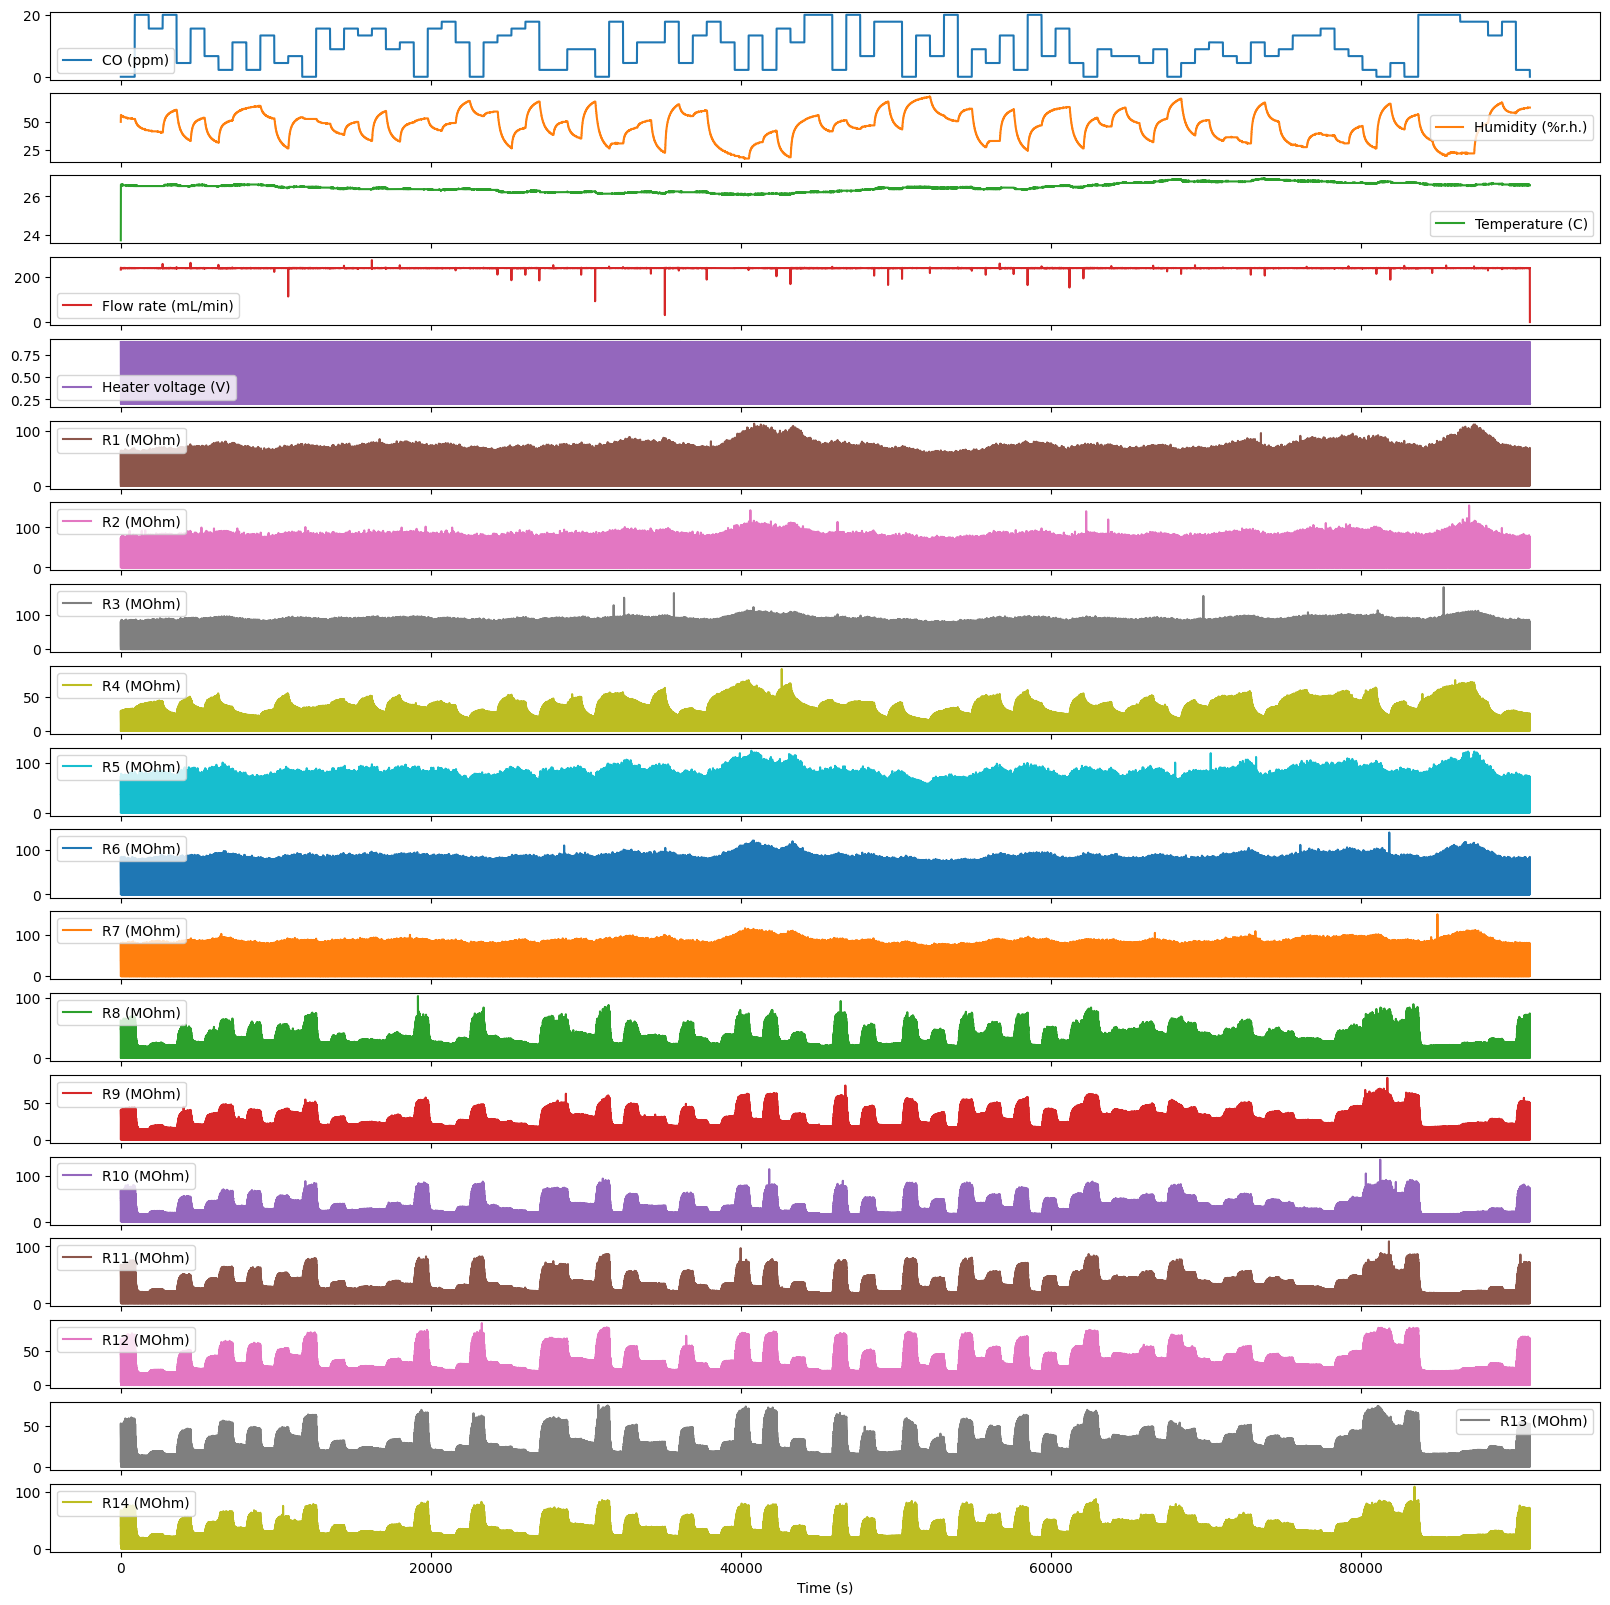

In [31]:
# df_20160930_203718のTime (s)を横軸に、縦軸にそれ以外の列を取り、グラフを描画
df_20160930_203718.plot(x='Time (s)', subplots=True, figsize=(20, 20))
plt.show()

In [32]:
# X_train, y_train, X_valid, y_validを作成
X_train = train.drop(columns=['Time (s)', 'CO (ppm)'])
y_train = train['CO (ppm)']
X_valid = valid.drop(columns=['Time (s)', 'CO (ppm)'])
y_valid = valid['CO (ppm)']

In [33]:
params = {
    "objective": "regression",
    "learning_rate": 0.01,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state":42,
    "max_depth": 5,
    "n_estimators": 10000, # "n_estimators": 1000ではearly_stopping(stopping_rounds=10)で収束しない
    "colsample_bytree": 0.7,
}
model = lgbm.LGBMRegressor(**params)
model.fit(
          X_train, y_train,
          eval_set = [(X_valid, y_valid)],
          eval_metric = "rmse",
          callbacks=[lgbm.early_stopping(stopping_rounds=10)]
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4505
[LightGBM] [Info] Number of data points in the train set: 3547543, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.900698
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with p

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01, max_depth=5,
              n_estimators=10000, objective='regression', random_state=42,
              reg_alpha=0.1, reg_lambda=0.1)

In [34]:
# vallidの予測値を求める
valid_preds = model.predict(X_valid, num_iteration=model.best_iteration_)
# validの予測値と正解値でRMSEとMAEを求める
rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mae = mean_absolute_error(y_valid, valid_preds)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE: 2.1415874500510155
MAE: 1.2257499607309452


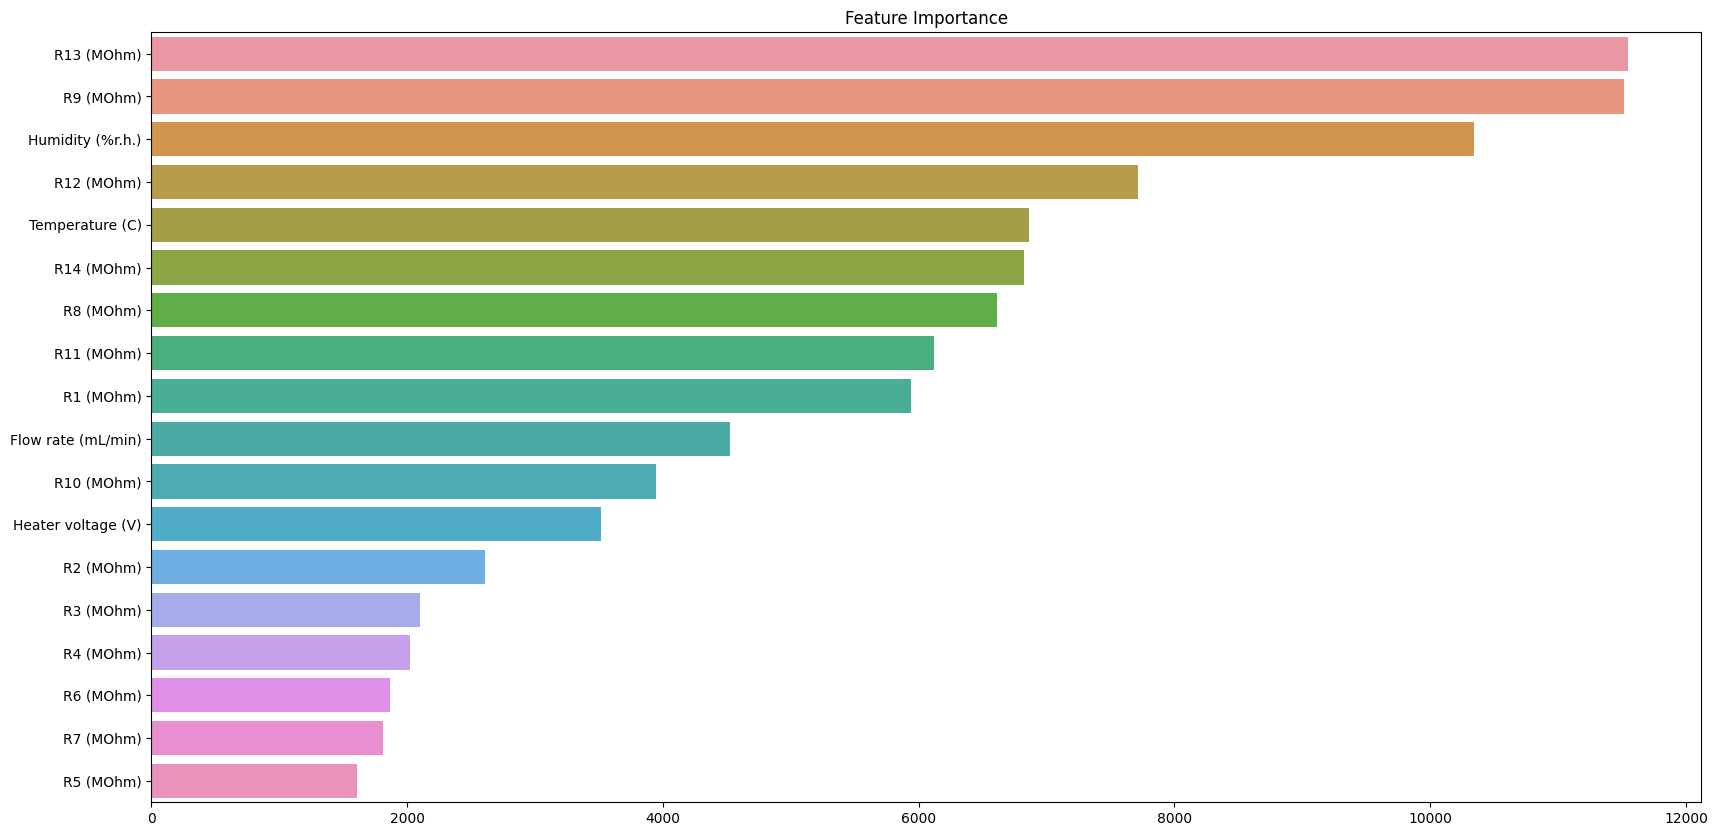

In [35]:
# modelのfeature_importances_を取得
feature_importance = model.feature_importances_
# feature_importanceを大きい順に並び替え
indices = np.argsort(feature_importance)[::-1]
# feature_importanceを可視化
plt.figure(figsize=(20, 10))
plt.title("Feature Importance")
sns.barplot(x=feature_importance[indices], y=X_train.columns[indices])
plt.show()

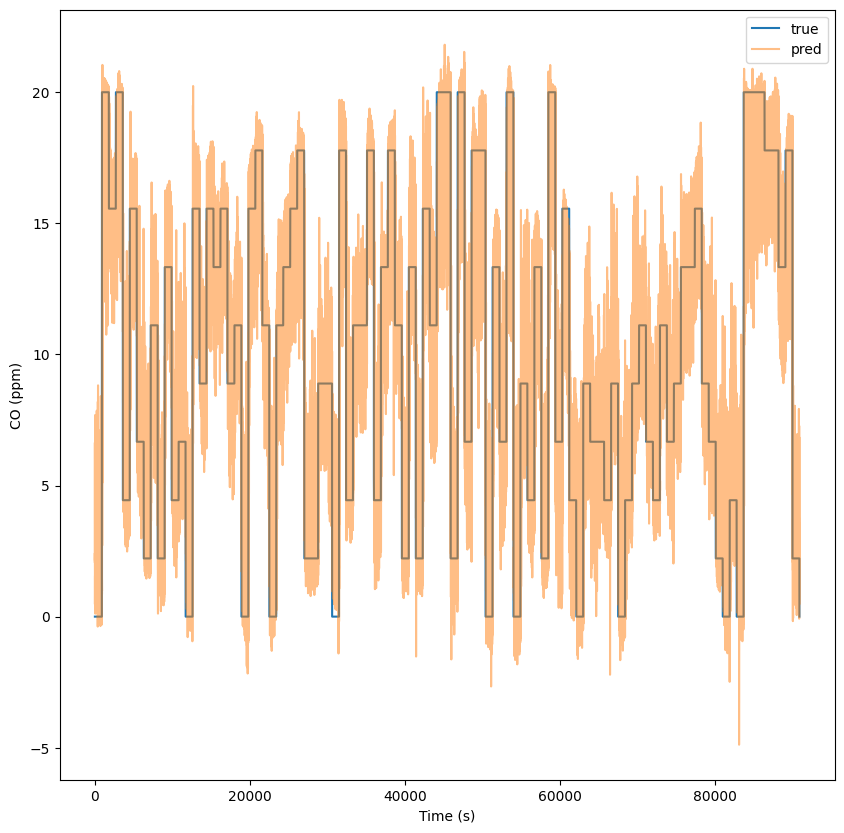

In [36]:
# y_valid, valid_predsを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid['Time (s)'], y_valid, label='true')
plt.plot(valid['Time (s)'], valid_preds, label='pred', alpha=0.5)
# 縦軸、横軸にラベルを付ける
plt.xlabel('Time (s)')
plt.ylabel('CO (ppm)')
plt.legend()

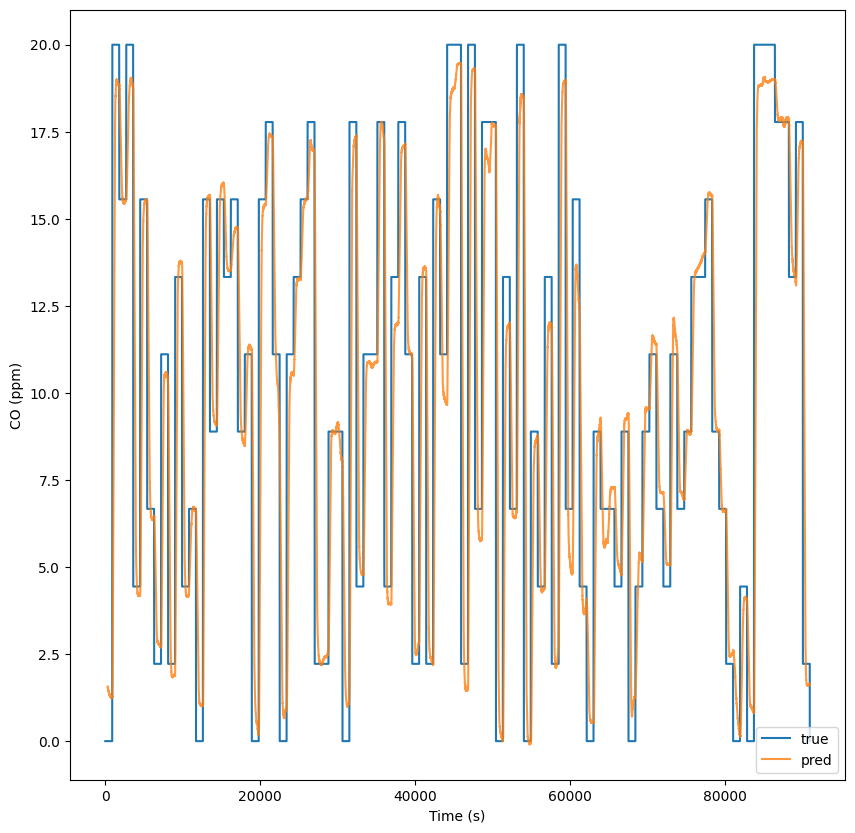

In [37]:
# predを移動平均で平滑化
pred = pd.Series(valid_preds)
pred_smooth = pred.rolling(window=1000).mean()
# y_valid, pred_smoothを縦軸、横軸にTime (s)を取り、グラフを描画
plt.figure(figsize=(10, 10))
plt.plot(valid['Time (s)'], y_valid, label='true')
plt.plot(valid['Time (s)'], pred_smooth, label='pred', alpha=0.8)
# 縦軸、横軸にラベルを付ける
plt.xlabel('Time (s)')
plt.ylabel('CO (ppm)')
plt.legend()